In [1]:
%load_ext autoreload
%autoreload 2
%pip install tqdm
%pip install torch torchinfo torchvision
%pip install pandas
%pip install imageio
%pip install numpy matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torch import nn
from torchinfo import summary
import torch.optim.lr_scheduler as lrs
# torch.set_grad_enabled(True)


import time

import sys
import os

sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))


from data_loader import plants_dataloader
from model3 import PlantNet, PlantNetNoCrop
from train import train
from generator import PlantLoss

In [3]:
csv_file = r"../data/images.1000.csv"
csv_eval = r"../data/images.200.csv"

In [4]:
BASE_EPOCHS = 12
RESET = False

In [5]:
dl_train = plants_dataloader(csv_file, batch_size=8, device="cuda")
dl_test = plants_dataloader(csv_eval, batch_size=8, device="cuda")

print(dl_train.dataset[0])

loss_fn = PlantLoss()
loss_fn.zero_grad()

(tensor([[[[  0.,   0.,   0.,  ..., 199., 199., 199.],
          [  0.,   0.,   0.,  ..., 199., 199., 199.],
          [  0.,   0.,   0.,  ..., 199., 199., 199.],
          ...,
          [  0.,   0.,   0.,  ..., 168., 168., 166.],
          [  0.,   0.,   0.,  ..., 168., 169., 167.],
          [  0.,   0.,   0.,  ..., 101., 108., 110.]],

         [[  0.,   0.,   0.,  ..., 237., 237., 237.],
          [  0.,   0.,   0.,  ..., 238., 238., 238.],
          [  0.,   0.,   0.,  ..., 237., 237., 237.],
          ...,
          [  0.,   0.,   0.,  ..., 228., 229., 228.],
          [  0.,   0.,   0.,  ..., 229., 230., 229.],
          [  0.,   0.,   0.,  ..., 162., 172., 177.]],

         [[  0.,   0.,   0.,  ..., 253., 253., 253.],
          [  0.,   0.,   0.,  ..., 253., 253., 253.],
          [  0.,   0.,   0.,  ..., 253., 253., 253.],
          ...,
          [  0.,   0.,   0.,  ..., 252., 253., 252.],
          [  0.,   0.,   0.,  ..., 253., 253., 252.],
          [  0.,   0.,   0.,  ..

In [6]:
list_activations = [
    nn.ELU,
    nn.Hardshrink,
    nn.Hardsigmoid,
    nn.Hardtanh,
    nn.Hardswish,
    nn.LeakyReLU,
    nn.LogSigmoid,
    nn.PReLU,
    nn.ReLU,
    nn.ReLU6,
    nn.RReLU,
    nn.SELU,
    nn.CELU,
    nn.GELU,
    nn.Sigmoid,
    nn.SiLU,
    nn.Mish,
    nn.Softplus,
    nn.Softshrink,
    nn.Softsign,
    nn.Tanh,
    nn.Tanhshrink,
    nn.Softmin,
    nn.Softmax,
    nn.LogSoftmax,
]


import random

random_act = lambda : random.choice(list_activations)()



In [7]:
if RESET or not "listnets1" in locals():
    listnets1 = (
        [PlantNet(nn.ELU), PlantNetNoCrop(nn.ELU)]
        # [OriginalNet(activation) for activation in list_activations] + [OriginalNet(random_act) for _ in range(5)]
        # if FULL==Training.FULL
        # else [
        #     OriginalNet(nn.RReLU),
        #     OriginalNet(nn.LeakyReLU),
        #     OriginalNet(nn.CELU),
        #     OriginalNet(nn.Mish),
        #     OriginalNet(nn.ELU),
        #     OriginalNet(nn.Hardtanh),
        #     OriginalNet(nn.Tanh),
        # ]
        # if FULL == Training.PARTIAL
        # else [OriginalNet(nn.RReLU)]
    )

    names1 = (
        ["PlantNetv1", "PlantNetNoCrop"]
        # [str(activation()) for activation in list_activations] + [f"random{n}" for n in range(5)]
        # if FULL==Training.FULL
        # else [
        #     "RReLU",
        #     "LeakyReLU",
        #     "CELU",
        #     "Mish",
        #     "ELU",
        #     "Hardtanh",
        #     "Tanh",
        # ]
        # if FULL == Training.PARTIAL
        # else ["nn.LeakyReLU"]
    )



print("\n\nvs\n\n".join(str(summary(net, (1, 3, 640, 480))) for net in listnets1))

Layer (type:depth-idx)                   Output Shape              Param #
PlantNet                                 [36, 2]                   --
├─Sequential: 1-1                        [1, 36, 320, 240]         --
│    └─Conv2d: 2-1                       [1, 9, 640, 480]          6,084
│    └─ELU: 2-2                          [1, 9, 640, 480]          --
│    └─Conv2d: 2-3                       [1, 18, 640, 480]         4,068
│    └─MaxPool2d: 2-4                    [1, 18, 320, 240]         --
│    └─Conv2d: 2-5                       [1, 36, 320, 240]         5,868
├─Sequential: 1-2                        [1, 36, 5]                --
│    └─ELU: 2-6                          [1, 36, 320, 240]         --
│    └─Centroids2d: 2-7                  [1, 36, 5]                36
│    │    └─Normalize2d: 3-1             [36, 320, 240]            --
│    │    └─Normalize2d: 3-2             [36, 320, 240]            --
│    └─ELU: 2-8                          [1, 36, 5]                --
├─Cent

In [8]:
if RESET or not "results1" in locals():
    results1: list[dict[str, list[float]]] = [
        {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": [], "move_final_acc":[]}
        for _ in range(len(listnets1))
    ]

    optimizers1 = [torch.optim.Adam(net.parameters(), lr=.0005) for net in listnets1]
    schedulers1 = [lrs.ExponentialLR(optimizer, .99) for optimizer in optimizers1]

    loss_fn = PlantLoss()


In [9]:
assert len(names1)==len(listnets1)

if RESET or not "times1" in locals():
    times1 = []
begin = len(times1)

for net, optimizer, scheduler, result, name in zip(
    listnets1, optimizers1, schedulers1, results1, names1
):
    # print(f"Training model {name}...{(len(times1)+1)%len(listnets1)}/{len(listnets1)}")
    print(f"Training model {name}...{len(times1)-begin+1}/{len(listnets1)}")

    torch.cuda.empty_cache()
    time_taken = time.time()
    result = train(
        net,
        dl_train,
        dl_test,
        loss_fn,
        optimizer,
        scheduler,
        result,
        device="cuda",
        epochs=BASE_EPOCHS,
    )
    time_taken = time.time() - time_taken
    print(f"total time: {time_taken}")
    times1.append(time_taken)

Training model PlantNetv1...1/2
Starting epoch 1/12


  0%|          | 0/125 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:05<00:00,  4.89it/s]


Epoch: 1/12 | train_loss: 0.107829 | train_acc: 0.892171 | test_loss: 0.018301 | test_acc: 0.981699 | lr: 0.000500
Starting epoch 2/12


100%|██████████| 25/25 [00:04<00:00,  5.03it/s]


Epoch: 2/12 | train_loss: 0.021823 | train_acc: 0.978177 | test_loss: 0.018116 | test_acc: 0.981884 | lr: 0.000495
Starting epoch 3/12


100%|██████████| 25/25 [00:04<00:00,  5.57it/s]


Epoch: 3/12 | train_loss: 0.021312 | train_acc: 0.978688 | test_loss: 0.017947 | test_acc: 0.982053 | lr: 0.000490
Starting epoch 4/12


100%|██████████| 25/25 [00:04<00:00,  6.24it/s]


Epoch: 4/12 | train_loss: 0.021043 | train_acc: 0.978957 | test_loss: 0.018144 | test_acc: 0.981856 | lr: 0.000485
Starting epoch 5/12


100%|██████████| 25/25 [00:04<00:00,  6.24it/s]


Epoch: 5/12 | train_loss: 0.020859 | train_acc: 0.979141 | test_loss: 0.018230 | test_acc: 0.981770 | lr: 0.000480
Starting epoch 6/12


100%|██████████| 25/25 [00:04<00:00,  6.15it/s]


Epoch: 6/12 | train_loss: 0.020684 | train_acc: 0.979316 | test_loss: 0.017876 | test_acc: 0.982124 | lr: 0.000475
Starting epoch 7/12


100%|██████████| 25/25 [00:04<00:00,  6.18it/s]


Epoch: 7/12 | train_loss: 0.020505 | train_acc: 0.979495 | test_loss: 0.017717 | test_acc: 0.982283 | lr: 0.000471
Starting epoch 8/12


100%|██████████| 25/25 [00:04<00:00,  5.26it/s]


Epoch: 8/12 | train_loss: 0.020367 | train_acc: 0.979633 | test_loss: 0.017713 | test_acc: 0.982287 | lr: 0.000466
Starting epoch 9/12


100%|██████████| 25/25 [00:04<00:00,  6.09it/s]


Epoch: 9/12 | train_loss: 0.020276 | train_acc: 0.979724 | test_loss: 0.017749 | test_acc: 0.982251 | lr: 0.000461
Starting epoch 10/12


100%|██████████| 25/25 [00:04<00:00,  6.16it/s]


Epoch: 10/12 | train_loss: 0.020250 | train_acc: 0.979750 | test_loss: 0.017707 | test_acc: 0.982293 | lr: 0.000457
Starting epoch 11/12


100%|██████████| 25/25 [00:04<00:00,  6.16it/s]


Epoch: 11/12 | train_loss: 0.020238 | train_acc: 0.979762 | test_loss: 0.017541 | test_acc: 0.982459 | lr: 0.000452
Starting epoch 12/12


100%|██████████| 25/25 [00:04<00:00,  6.14it/s]


Epoch: 12/12 | train_loss: 0.020089 | train_acc: 0.979911 | test_loss: 0.017444 | test_acc: 0.982556 | lr: 0.000448
[]
total time: 385.0961513519287
Training model PlantNetNoCrop...2/2
Starting epoch 1/12


100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


Epoch: 1/12 | train_loss: 0.350528 | train_acc: 0.649472 | test_loss: 0.017355 | test_acc: 0.982645 | lr: 0.000500
Starting epoch 2/12


100%|██████████| 25/25 [00:03<00:00,  6.27it/s]


Epoch: 2/12 | train_loss: 0.020610 | train_acc: 0.979390 | test_loss: 0.016719 | test_acc: 0.983281 | lr: 0.000495
Starting epoch 3/12


100%|██████████| 25/25 [00:03<00:00,  6.30it/s]


Epoch: 3/12 | train_loss: 0.019383 | train_acc: 0.980617 | test_loss: 0.017519 | test_acc: 0.982481 | lr: 0.000490
Starting epoch 4/12


100%|██████████| 25/25 [00:04<00:00,  6.11it/s]


Epoch: 4/12 | train_loss: 0.018776 | train_acc: 0.981224 | test_loss: 0.017032 | test_acc: 0.982968 | lr: 0.000485
Starting epoch 5/12


100%|██████████| 25/25 [00:04<00:00,  6.23it/s]


Epoch: 5/12 | train_loss: 0.017822 | train_acc: 0.982178 | test_loss: 0.017342 | test_acc: 0.982658 | lr: 0.000480
Starting epoch 6/12


100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


Epoch: 6/12 | train_loss: 0.017139 | train_acc: 0.982861 | test_loss: 0.019386 | test_acc: 0.980614 | lr: 0.000475
Starting epoch 7/12


100%|██████████| 25/25 [00:04<00:00,  6.17it/s]


Epoch: 7/12 | train_loss: 0.017518 | train_acc: 0.982482 | test_loss: 0.017398 | test_acc: 0.982602 | lr: 0.000471
Starting epoch 8/12


100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


Epoch: 8/12 | train_loss: 0.017423 | train_acc: 0.982577 | test_loss: 0.019310 | test_acc: 0.980690 | lr: 0.000466
Starting epoch 9/12


100%|██████████| 25/25 [00:04<00:00,  6.23it/s]


Epoch: 9/12 | train_loss: 0.016764 | train_acc: 0.983236 | test_loss: 0.016314 | test_acc: 0.983686 | lr: 0.000461
Starting epoch 10/12


100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


Epoch: 10/12 | train_loss: 0.015299 | train_acc: 0.984701 | test_loss: 0.018932 | test_acc: 0.981068 | lr: 0.000457
Starting epoch 11/12


100%|██████████| 25/25 [00:03<00:00,  6.28it/s]


Epoch: 11/12 | train_loss: 0.015089 | train_acc: 0.984911 | test_loss: 0.017789 | test_acc: 0.982211 | lr: 0.000452
Starting epoch 12/12


100%|██████████| 25/25 [00:04<00:00,  5.47it/s]

Epoch: 12/12 | train_loss: 0.014214 | train_acc: 0.985786 | test_loss: 0.020486 | test_acc: 0.979514 | lr: 0.000448
[]
total time: 369.36336851119995


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[385.0961513519287, 369.36336851119995]
[{'train_loss': [0.10782945759594441, 0.021822599656879903, 0.021312222361564635, 0.021042822901159525, 0.02085939411446452, 0.0206839488632977, 0.020505041256546973, 0.02036721920594573, 0.020276459645479916, 0.020249632284045218, 0.02023818839341402, 0.020089388500899075], 'train_acc': [0.8921705393791198, 0.9781773996353149, 0.9786877784729003, 0.9789571766853332, 0.979140606880188, 0.9793160495758056, 0.979494957447052, 0.9796327829360962, 0.9797235407829284, 0.9797503681182861, 0.9797618131637573, 0.9799106125831604], 'test_loss': [0.018300857003778218, 0.01811594920232892, 0.017947289943695068, 0.01814355608075857, 0.01822958329692483, 0.017876228485256433, 0.017716986779123544, 0.01771322600543499, 0.0177489285543561, 0.01770680509507656, 0.01754086244851351, 0.01744412934407592], 'test_acc': [0.9816991376876831, 0.9818840551376343, 0.9820527100563049, 0.9818564438819886, 0.9817704153060913, 0.9821237778663635, 0.9822830128669738, 0.982286

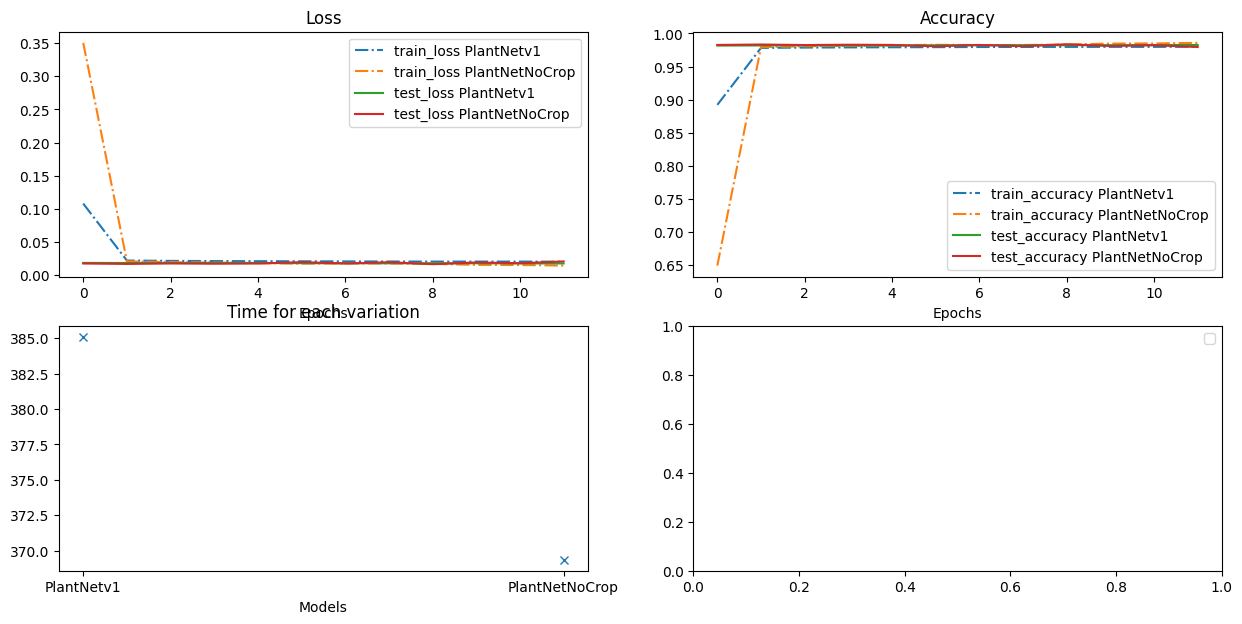

In [10]:
from train import plot_results
print(times1)
print(results1)

plot_results(*results1, names=names1, times=times1)
# resultssplit = [results1[5*i:5*(i+1)] for i in range(int(len(results1)/5+0.99))]
# namessplit = [names1[5*i:5*(i+1)] for i in range(int(len(names1)/5+0.99))]
# timessplit = [times1[5*i:5*(i+1)] for i in range(int(len(times1)/5+0.99))]

# for results_, names_, times_ in zip(resultssplit, namessplit, timessplit):
#     plot_results(*results_, names=names_, times=times_)
# pass

In [11]:
print(os.getcwd())
for net, name in zip(listnets1, names1):
    torch.save(net, f"""saves_models/{name.replace(" ", "").replace("'", "").replace("<", "").replace(">", "")}.{int(time.time())}.pth""")
print(int(time.time()))
print("ok")

import onnxscript
input_ = torch.randn(1, 3, 640, 480)
for model, name in zip([listnets1[1]], names1):

    onnx_program = torch.onnx.dynamo_export(listnets1[0], input_)
    onnx_program.save(f"{name}.onnx")


/home/ekter/Documents/Omniverse/polybot/exts/polybot.riviera/polybot/riviera/ai
1714845447
ok


/home/ekter/Documents/Omniverse/polybot/.venv/lib/python3.11/site-packages/torch/onnx/_internal/exporter.py:137: UserWarning: torch.onnx.dynamo_export only implements opset version 18 for now. If you need to use a different opset version, please register them with register_custom_op.
  warnings.warn(


OnnxExporterError: Failed to export the model to ONNX. Generating SARIF report at 'report_dynamo_export.sarif'. SARIF is a standard format for the output of static analysis tools. SARIF logs can be loaded in VS Code SARIF viewer extension, or SARIF web viewer (https://microsoft.github.io/sarif-web-component/). Please report a bug on PyTorch Github: https://github.com/pytorch/pytorch/issues